In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from biodatatools.utils.common import json_load
import glob
from sklearn.decomposition import PCA
import numpy as np
import pybedtools
from collections import defaultdict
import pandas as pd
from pathlib import Path

In [4]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/"
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"

# Get embeddings

In [5]:
labels = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/classifications.json")
groups = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/samples.json")
folders = glob.glob(f"{PROJECT_DIR_o}procapnet/deepshap_out/*")
samples = [folder.split("/")[-1] for folder in folders if folder.split("/")[-1] in groups["normal_tissues"]]

In [38]:
# In ProCapNet paper, when they compare PCA of embeddings of promoters vs. enhancers, they defined embeddings as the outputs of the global average pooling layer, which follows the final dilated convolution layer that is shared between the profile and counts task heads.

model_type = "strand_merged_umap"
script = f"{PROJECT_DIR_s}slurm/embeddings.sh"
for s in samples:
	commands = [f"sbatch {script}",
				s,
				model_type,
				f"{PROJECT_DIR_o}procapnet/processed/{s}/peaks.bed.gz",
				PROJECT_DIR_o,
				f"{PROJECT_DIR_o}procapnet/embeddings/{s}."
				]
	print(" ".join(commands))

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/embeddings.sh EN5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/processed/EN5/peaks.bed.gz /home/yc2553/projects/HEA/output/ /home/yc2553/projects/HEA/output/procapnet/embeddings/EN5.
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/embeddings.sh BCT5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/processed/BCT5/peaks.bed.gz /home/yc2553/projects/HEA/output/ /home/yc2553/projects/HEA/output/procapnet/embeddings/BCT5.
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/embeddings.sh EN55 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/processed/EN55/peaks.bed.gz /home/yc2553/projects/HEA/output/ /home/yc2553/projects/HEA/output/procapnet/embeddings/EN55.
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/embeddings.sh EN18 strand_merged_umap /home/yc2553/projects/HEA/output

In [6]:
pcs = {}
pca_trans = {}
for s in samples:
    inputfile = f"{PROJECT_DIR_o}procapnet/embeddings/{s}.embeddings.npy"
    data = np.load(inputfile)
    pca = PCA(random_state=42)
    pcs[s] = pca.fit(data)
    pca_trans[s] = pca.fit_transform(data)

In [7]:
def plot_pc_frac_variances(pcs):
	fig, ax = plt.subplots(figsize=(4,3))
	n = 10 if len(pcs.explained_variance_ratio_) > 10 else len(pcs.explained_variance_ratio_)
	g = sns.barplot(x=range(1, n+1), y=pcs.explained_variance_ratio_[:10], ax=ax)
	g.set_xlabel("Principal component", fontsize=bfontsize)
	g.set_ylabel("Frac. variance explained", fontsize=bfontsize)
	g.spines[["right", "top"]].set_visible(False)

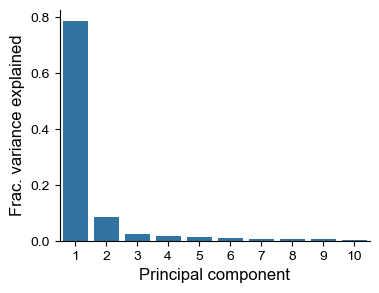

In [8]:
s = "EN55"
plot_pc_frac_variances(pcs[s])

# Plot embeddings

## Distal vs. proximal

In [17]:
pc_labels = defaultdict(dict)
b1 = pybedtools.BedTool(f"{PROJECT_DIR_r}genomes/human/gencode.v37.annotation.TSS.500.bed.bgz")
es_all = {}
for s in pcs:
    b2 = pybedtools.BedTool(f"{PROJECT_DIR_o}procapnet/processed/{s}/peaks.bed.gz")
    es_all[s] = ["_".join(i.fields[:3]) for i in b2]
    pc_labels[s]["Proximal"] = [es_all[s].index("_".join(i.fields[:3])) for i in b2.intersect(b1, u=True)]
    pc_labels[s]["Distal"] = [es_all[s].index("_".join(i.fields[:3])) for i in b2.intersect(b1, v=True)]

In [18]:
def label_trans_data(df_pc, labels, keys, colname="Label"):
    conditions = [df_pc.index.isin(labels[k]) for k in keys]
    df_pc[colname] = np.select(conditions, keys, default=None)
    return df_pc

In [19]:
df_pcs = {}
for s in pcs:
    df_pc = pd.DataFrame(pca_trans[s])[[0,1]]
    df_pc.columns = ["PC1", "PC2"]
    df_pcs[s] = label_trans_data(df_pc, pc_labels[s], ["Proximal", "Distal"])

In [31]:
def plot_embeddings(s, df, pcs, ax, palette, hue, hue_order, title, legend):
	g = sns.scatterplot(data=df, x="PC1", y="PC2", s=2, alpha=0.7,
						hue=hue, hue_order=hue_order, palette=palette, ax=ax)
	g.spines[["right", "top"]].set_visible(False)
	g.set_title(title, fontsize=bfontsize)
	frac1, frac2 = [round(pcs.explained_variance_ratio_[n]*100,1) for n in range(2)]
	g.set_xlabel(f"PC1 ({frac1}%)", fontsize=bfontsize)
	g.set_ylabel(f"PC2 ({frac2}%)", fontsize=bfontsize)
	g.yaxis.set_label_coords(-0.5, 0.5)
	
	if legend:
		g.legend(fontsize=sfontsize, loc="upper center",  bbox_to_anchor=(0.5, 1.7), 
				 markerscale=5, handletextpad=0.1, ncol=2, frameon=False)
	else:
		g.legend([], [], frameon=False)

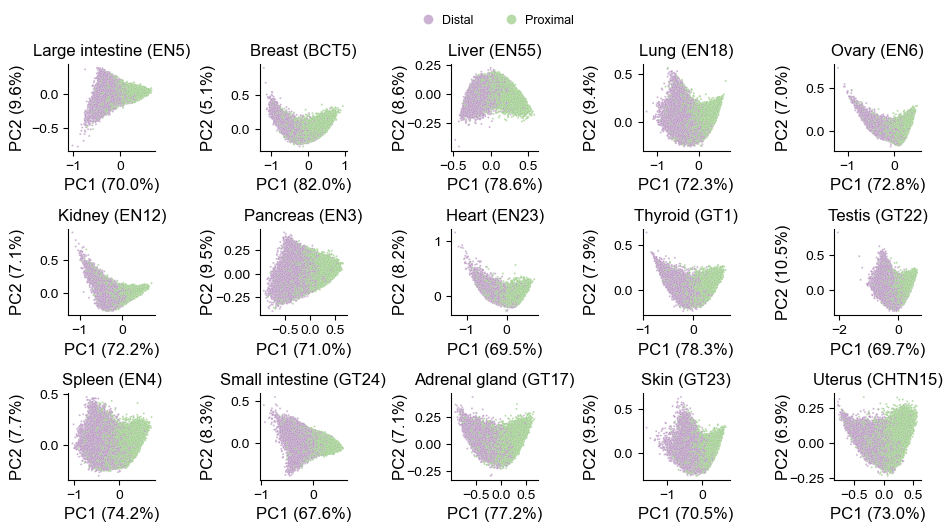

In [33]:
fig, ax = plt.subplots(3, 5, figsize=(11,5.4))
for s in samples:
    row = samples.index(s)//5
    col = samples.index(s)%5
    legend = True if row == 0 and col == 2 else False
    plot_embeddings(s, df_pcs[s], pcs[s], ax[row, col], ["#B591BF", "#97CB84"], "Label", ["Distal", "Proximal"], f"{labels[s][1]} ({s})", legend)
plt.subplots_adjust(wspace=1.2, hspace=0.9)
plt.savefig(f"{PROJECT_DIR_o}figures/SuppFig5a.png", bbox_inches="tight", dpi=300, transparent=True)

## Divergent vs. unidirectional

In [23]:
beds = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/sample_beds.json")

In [24]:
for s in pcs:
    b1 = pybedtools.BedTool(f"{PROJECT_DIR_o}procapnet/processed/{s}/peaks.bed.gz")
    b2 = pybedtools.BedTool(beds[s][0])
    pc_labels[s]["Divergent"] = [es_all[s].index("_".join(i.fields[:3])) for i in b1.intersect(b2, u=True)]
    pc_labels[s]["Unidirectional"] = [es_all[s].index("_".join(i.fields[:3])) for i in b1.intersect(b2, v=True)]

In [25]:
for s in pcs:
    df_pcs[s] = label_trans_data(df_pcs[s], pc_labels[s], ["Divergent", "Unidirectional"], "Label2")

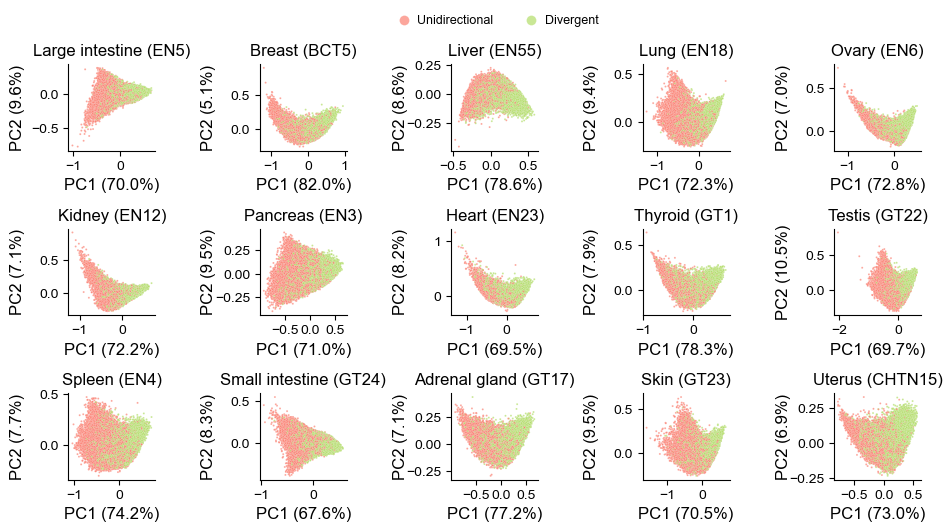

In [34]:
fig, ax = plt.subplots(3, 5, figsize=(11,5.4))
for s in samples:
    row = samples.index(s)//5
    col = samples.index(s)%5
    legend = True if row == 0 and col == 2 else False
    plot_embeddings(s, df_pcs[s], pcs[s], ax[row, col], ["#fb8072", "#b3de69"], "Label2", ["Unidirectional", "Divergent"], f"{labels[s][1]} ({s})", legend)
plt.subplots_adjust(wspace=1.2, hspace=0.9)
plt.savefig(f"{PROJECT_DIR_o}figures/SuppFig5b.png", bbox_inches="tight", dpi=300, transparent=True)